In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_parquet("hf://datasets/tonyassi/celebrity-1000/data/train-00000-of-00001.parquet")

df['bytes'] = df['image'].apply(lambda x: x['bytes'])
df['path'] = df['image'].apply(lambda x: x['path'])

df = df.drop(columns=['image'])


/home/filip/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df.head()

,label,bytes,path
0,0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,Aaron-Eckhart0.jpg
1,0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,Aaron-Eckhart1.jpg
2,0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,Aaron-Eckhart10.jpg
3,0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,Aaron-Eckhart11.jpg
4,0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,Aaron-Eckhart12.jpg


In [3]:
import os
import re
from PIL import Image
from io import BytesIO

image_dir = "images_data"

os.makedirs(image_dir, exist_ok=True)

def convert_filename(filename):
    name_without_extension = filename.replace('.', '')[:-3]

    
    name_lower = name_without_extension.lower()
    converted_name = re.sub(r'[^a-z]+', '_', name_lower)
    
    return converted_name[:-1]

for index, row in df.iterrows():
    try:

        label_dir = os.path.join(image_dir, convert_filename(row['path']))
        os.makedirs(label_dir, exist_ok=True)

        image_filename = os.path.join(label_dir, row['path'])
        if not os.path.exists(image_filename):
            img = Image.open(BytesIO(row['bytes'])) 
            img = img.convert("RGB") 
            img.save(image_filename, "JPEG")
            print(f"Saved {image_filename}")
        df.loc[index, 'path'] = image_filename
        
    except Exception as e:
        print(f"Error saving image for row {index}: {e}")

df = df.drop(columns=['bytes']) # no longer needed
df['label'] = df['label'].astype(str) # ImageDataGenerator takes y input in type string
df.head()

Saved images_data/aaron_eckhart/Aaron-Eckhart0.jpg
Saved images_data/aaron_eckhart/Aaron-Eckhart1.jpg
Saved images_data/aaron_eckhart/Aaron-Eckhart10.jpg
Saved images_data/aaron_eckhart/Aaron-Eckhart11.jpg
Saved images_data/aaron_eckhart/Aaron-Eckhart12.jpg
Saved images_data/aaron_eckhart/Aaron-Eckhart13.jpg
Saved images_data/aaron_eckhart/Aaron-Eckhart14.jpg
Saved images_data/aaron_eckhart/Aaron-Eckhart15.jpg
Saved images_data/aaron_eckhart/Aaron-Eckhart16.jpg
Saved images_data/aaron_eckhart/Aaron-Eckhart2.jpg
Saved images_data/aaron_eckhart/Aaron-Eckhart3.jpg
Saved images_data/aaron_eckhart/Aaron-Eckhart4.jpg
Saved images_data/aaron_eckhart/Aaron-Eckhart5.jpg
Saved images_data/aaron_eckhart/Aaron-Eckhart6.jpg
Saved images_data/aaron_eckhart/Aaron-Eckhart7.jpg
Saved images_data/aaron_eckhart/Aaron-Eckhart8.jpg
Saved images_data/aaron_eckhart/Aaron-Eckhart9.jpg
Saved images_data/aaron_paul/Aaron-Paul0.jpg
Saved images_data/aaron_paul/Aaron-Paul1.jpg
Saved images_data/aaron_paul/Aaron-P

,label,path
0,0,images_data/aaron_eckhart/Aaron-Eckhart0.jpg
1,0,images_data/aaron_eckhart/Aaron-Eckhart1.jpg
2,0,images_data/aaron_eckhart/Aaron-Eckhart10.jpg
3,0,images_data/aaron_eckhart/Aaron-Eckhart11.jpg
4,0,images_data/aaron_eckhart/Aaron-Eckhart12.jpg


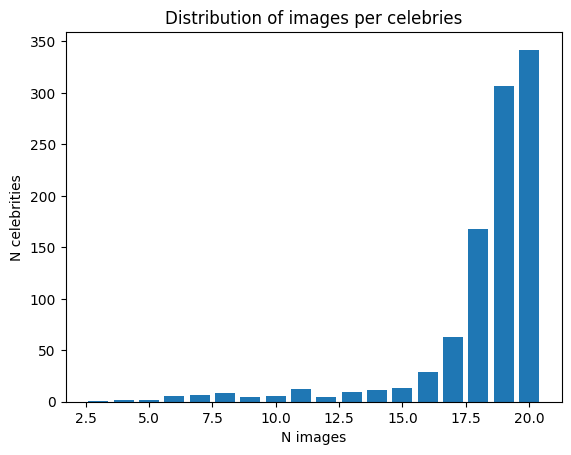

In [17]:
import matplotlib.pyplot as plt
counts = {}

for dir in os.listdir('images_data/'):
    path = os.path.join('images_data/', dir)
    if not os.path.isdir(path):
        continue
    n_files = len(os.listdir(path))
    if not n_files in counts:
        counts[n_files] = 1
    else:
        counts[n_files] += 1
    
max_n_files = max(counts.keys())
min_n_files = min(counts.keys())

plt.bar(list(counts.keys()), list(counts.values()))

plt.xlabel('N images')
plt.ylabel('N celebrities')
plt.title('Distribution of images per celebries')

plt.show()


In [4]:

train_ratio=0.8

train_df, test_df = train_test_split(df, train_size=train_ratio, stratify=df['label'])

# Duplicating pictures of Tyrone Gibson (who?) for some reason there're not put into the test ds
# Caused mismatch in shapes
df_label_954 = df[df['label'] == '954']
test_df = pd.concat([test_df, df_label_954])

train_labels = set(train_df['label'])
test_labels = set(test_df['label'])

print("Training set size:", len(train_df))
print("Test set size:", len(test_df))


Training set size: 14547
Test set size: 3640


In [5]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
rows=256  #Number of Pixels in the Rows for Input. 
cols=256  #Number of Pixels in Columns for Output

2024-11-15 17:33:08.088748: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731688389.443750    4396 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731688389.613669    4396 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-15 17:33:11.867461: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
trained_model=MobileNetV2(input_shape=(rows,cols,3),           
                    include_top=False,
                    weights='imagenet')   


trained_model.trainable=True  #Un-Freeze all the pretrained layers of 'MobileNetV2 for Training.
    
trained_model.summary()

/tmp/ipykernel_4396/620238923.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  trained_model=MobileNetV2(input_shape=(rows,cols,3),
I0000 00:00:1731688415.469121    4396 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4964 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 128,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 128, 128,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 128, 128,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 128, 128,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 128, 128,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 128, 128,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 129, 129,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 64, 64,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 64, 64,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [7]:
last_layer=trained_model.get_layer('out_relu')   
last_layer_output=last_layer.output  #Saves the output of the last layer of the MobileNetV2.

In [8]:
#Callback Function which stops training when accuracy reaches target %.

target_acc = 0.9

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > target_acc):
      print("\nReached 98% accuracy so cancelling training!")
      self.model.stop_training = True
callbacks=myCallback()

model_path = 'celeb_recognition.keras'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path,
    save_best_only=True,
    monitor='accuracy',
    mode='max',
    verbose=1
)

In [9]:
if os.path.exists(model_path):
    model = tf.keras.models.load_model(model_path)
    print(f"Model loaded from {model_path}")
else:
    n_classes = 997
    x = tf.keras.layers.GlobalAveragePooling2D()(last_layer_output)
    #Add a Dropout layer.
    x = tf.keras.layers.Dropout(0.8)(x)                      
    # Add a final softmax layer for classification.
    x = tf.keras.layers.Dense(n_classes, activation='softmax')(x)
    
    model = tf.keras.Model(trained_model.input,x) 
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(1e-4),
                  metrics=['accuracy'])
    #Summary of the model.
model.summary()

Model loaded from celeb_recognition.keras


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 128,  │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 128, 128,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 128, 128,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 128, 128,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 128, 128,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 128, 128,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 129, 129,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 64, 64,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 64, 64,    │      2,304 │ block_1_depthwis

 Total params: 10,537,201 (40.20 MB)

 Trainable params: 3,501,029 (13.36 MB)

 Non-trainable params: 34,112 (133.25 KB)

 Optimizer params: 7,002,060 (26.71 MB)

In [10]:
train_df['label'] = train_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)
train_datagen = ImageDataGenerator(rescale=1/255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 rotation_range=40,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1)
                                 
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator=train_datagen.flow_from_dataframe(
                                                  dataframe=train_df,
                                                  target_size=(rows,cols),
                                                  x_col='path',
                                                  y_col = 'label',
                                                  class_mode='categorical')

test_generator=test_datagen.flow_from_dataframe(
                                                dataframe=test_df,
                                                target_size=(rows,cols),
                                                x_col='path',
                                                y_col = 'label',
                                                class_mode='categorical')

Found 14547 validated image filenames belonging to 997 classes.
Found 3640 validated image filenames belonging to 997 classes.


In [11]:
epochs=30

result=model.fit(train_generator,
                 validation_data=test_generator,
                 epochs=epochs,
                 callbacks=[callbacks, checkpoint_callback],
                 verbose=1)

Epoch 1/30


/home/filip/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731688450.840897    5727 service.cc:148] XLA service 0x7f8cb8004250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731688450.840917    5727 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2024-11-15 17:34:11.647593: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731688454.870282    5727 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-15 17:34:31.542044: E external/local_xla/

236/455 ━━━━━━━━━━━━━━━━━━━━ 1:22 376ms/step - accuracy: 0.3773 - loss: 2.6196

E0000 00:00:1731688586.872548    5727 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731688587.002679    5727 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.3770 - loss: 2.6195
Epoch 1: accuracy improved from -inf to 0.37884, saving model to celeb_recognition.keras
455/455 ━━━━━━━━━━━━━━━━━━━━ 271s 456ms/step - accuracy: 0.3770 - loss: 2.6195 - val_accuracy: 0.6846 - val_loss: 1.6773
Epoch 2/30
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.4151 - loss: 2.4319
Epoch 2: accuracy improved from 0.37884 to 0.41754, saving model to celeb_recognition.keras
455/455 ━━━━━━━━━━━━━━━━━━━━ 179s 386ms/step - accuracy: 0.4151 - loss: 2.4319 - val_accuracy: 0.7071 - val_loss: 1.4720
Epoch 3/30
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.4510 - loss: 2.2396
Epoch 3: accuracy improved from 0.41754 to 0.44937, saving model to celeb_recognition.keras
455/455 ━━━━━━━━━━━━━━━━━━━━ 179s 386ms/step - accuracy: 0.4510 - loss: 2.2396 - val_accuracy: 0.7253 - val_loss: 1.3616
Epoch 4/30
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.4845 - loss: 2.0707
Epoch 4: accuracy impro

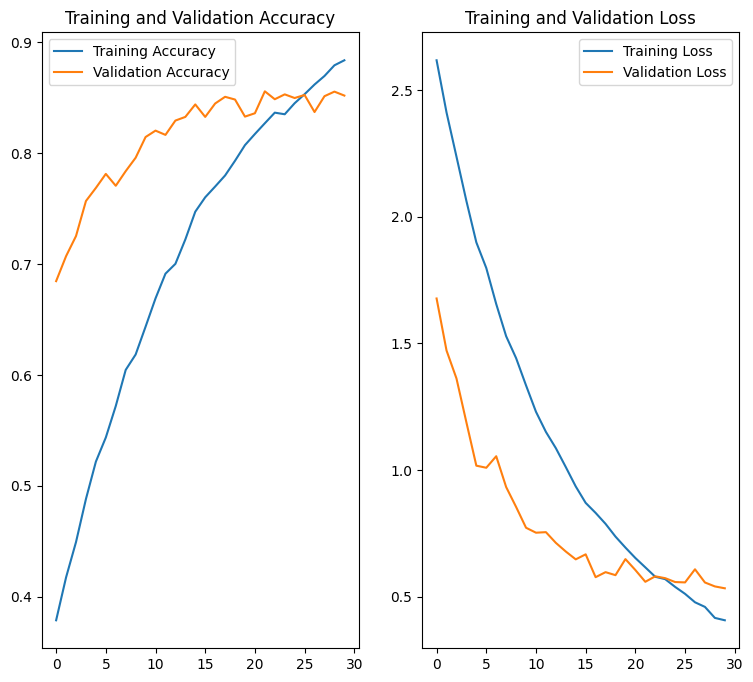

In [12]:
import matplotlib.pyplot as plt

acc = result.history['accuracy']
val_acc = result.history['val_accuracy']

loss = result.history['loss']
val_loss = result.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(9, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
import numpy as np

test_images = [os.path.join('test_images', image) for image in os.listdir('test_images')]

classes=train_generator.class_indices
class_ids=list(classes.keys())
celeb_names = pd.read_csv('celeb_names.csv')


def get_name(id):
    name = celeb_names.loc[celeb_names['id'] == id, 'name'].values
    if len(name) > 0:
        return name[0]
    else:
        return None

image_arrays = []

for image in test_images:
    img = tf.keras.preprocessing.image.load_img(
        image, target_size=(rows, cols)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0 
    image_arrays.append(img_array)

batch_array = np.stack(image_arrays, axis=0)

scores = model.predict(batch_array)

for i, score in enumerate(scores):
    top_5_indices = np.argsort(score)[-5:][::-1]
    top_5_celeb_ids = [int(class_ids[idx]) for idx in top_5_indices]
    top_5_names = [get_name(celeb_id) for celeb_id in top_5_celeb_ids]
    top_5_scores = [score[idx] * 100 for idx in top_5_indices]

    print(f"The person in {test_images[i]} looks like {top_5_names[0]}, likeness score of {top_5_scores[0]:.1f}%")
    print('Ohter honorable mentions are:')
    for s, n in zip(top_5_scores[1:], top_5_names[1:]):
        if s < 1:
            break
        print(f'{n}, likness score of {s:.1f}%')
    print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
The person in test_images/kanye_256.jpg looks like Lewis Hamilton, likeness score of 33.9%
Ohter honorable mentions are:
Usain Bolt, likness score of 22.3%
Aaron Rodgers, likness score of 21.4%
Idris Elba, likness score of 6.2%
Tiger Woods, likness score of 3.7%

The person in test_images/jolie_256.jpg looks like Annabelle Wallis, likeness score of 16.5%
Ohter honorable mentions are:
Naomi Watts, likness score of 9.4%
Kylie Minogue, likness score of 7.9%
Sarah Michelle Gellar, likness score of 7.7%
January Jones, likness score of 6.9%

The person in test_images/aaron_256.jpg looks like Aaron Paul, likeness score of 82.0%
Ohter honorable mentions are:
Nick Kroll, likness score of 5.0%
Aaron Taylor-Johnson, likness score of 2.4%
Sebastian Stan, likness score of 1.7%
Tom Felton, likness score of 1.6%

The person in test_images/carrey_256.jpg looks like Jim Carrey, likeness score of 48.9%
Ohter honorable mentions are:
Jon Bernthal, likness score of 25.